In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
from datetime import datetime, timedelta, date
import pickle
import warnings

#settings
warnings.filterwarnings("ignore")

appearances_df = pd.read_csv("../raw_data/appearances.csv")
clubs_df = pd.read_csv("../raw_data/clubs.csv")
games_df = pd.read_csv("../raw_data/games.csv")
players_df = pd.read_csv("../raw_data/players.csv")



def players_df_preproc(players_df):
    #add year to game valuations
    now = datetime.now()
    players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
    players_df = players_df[players_df['date_of_birth'].isnull() == False]
    players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
    players_df['age'] = players_df['age'].round().astype(int) 

    # Calculate the contract remaining of each player
    players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
    players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
    players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 
    return players_df

def appearances_df_preproc(appearances_df):
    # add year to player appearances
    appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
    appearances_df['year']=appearances_df['datetime'].dt.year
    appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
    return appearances_df
"""
def games_and_appearances_df_preproc(games_df,appearances_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    return games_and_appearances_df

def feature_encode(df,column):
    dummies=pd.get_dummies(df[column], prefix_sep='_') 
    df = pd.concat([df, dummies], axis=1)
    return df
    """

'\ndef games_and_appearances_df_preproc(games_df,appearances_df):\n    games_df[\'datetime\']=pd.to_datetime(games_df[\'date\'], format="%Y-%m-%d")\n    games_df[\'year\']=games_df[\'datetime\'].dt.year\n    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]\n    games_and_appearances_df = appearances_df.merge(games_df, on=[\'game_id\'], how=\'left\')\n    return games_and_appearances_df\n\ndef feature_encode(df,column):\n    dummies=pd.get_dummies(df[column], prefix_sep=\'_\') \n    df = pd.concat([df, dummies], axis=1)\n    return df\n    '

In [2]:
def games_and_appearances_df_preproc(games_df,appearances_df,clubs_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    
    # here we impute the missing values with the minimum value of the corresponding league 
    # get the minimum value of the 'Domestic League' column
    min_value = clubs_df.groupby('domestic_competition_id')['total_market_value'].min()
        
    # fill missing values in 'Market Value' column with the minimum value of the 'Domestic League' column
    clubs_df['total_market_value'] = clubs_df.apply(lambda x: min_value[x['domestic_competition_id']] if pd.isnull(x['total_market_value']) else x['total_market_value'], axis=1)
    
    table_df = games_and_appearances_df
    
    # Join the tables on the home and away club IDs
    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='home_club_id', 
                            right_on='club_id')

    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='away_club_id', 
                            right_on='club_id',
                            suffixes=('_home', '_away'))

    # Rename the columns to reflect the market value data
    table_df = table_df.rename(columns={'market_value_home': 'home_club_market_value',
                                        'market_value_away': 'away_club_market_value'})

    # Drop the redundant club_id columns
    table_df = table_df.drop(['club_id_home', 'club_id_away'], axis=1)
    
    games_and_appearances_df = table_df
    
    games_and_appearances_df.dropna(inplace=True)
    
    
    return games_and_appearances_df

In [3]:
#create a function to collate player stats
def player_stats(player_id, season, games_and_appearances_df):
    
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for',
                                                     'goals_against','clean_sheet',
                                                     'yellow_cards', 'red_cards','value_goals_for'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else np.nan if row['goals_against'] > 0
            else np.nan, axis=1)
        
        #engineering 
        df["value_goals_for"] = df.apply(lambda row: row['home_club_goals']*row['total_market_value_away'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals']*row['total_market_value_home'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        #print(df["value_goals_for"])
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                    'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                    'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum', 
                                                                    'red_cards':'sum',
                                                                    'value_goals_for':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df


In [4]:
# preprocessing function to return a dataframe
def data_cleaning(clubs_df,players_df,games_and_appearances_df):
    
    merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 
                                       'last_name', 'player_code', 'image_url', 'url'], axis=1)
    merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + 
                                                  ['club_value','squad_size','goals','goals_2022','games_2022',
                                                    'assists_2022','minutes_played_2022','goals_against_2022',
                                                    'goals_for_2022','clean_sheet_2022','value_goals_for_2022'])
    
    for player_id in merged_players_df.player_id.unique():
        club_id = players_df.current_club_id[(players_df.player_id==player_id)]
        try:
            merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
        except:
            merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
        merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))

    columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022',
             'clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship',
             'country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name',
             'contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur','value_goals_for_2022']
    merged_players_df=merged_players_df[columns] 

    #iterate through players
    for index in merged_players_df.index:
        id = merged_players_df.loc[index][0]
        name = merged_players_df.loc[index][1]
        
        season = 2022
        stats = player_stats(id, season, games_and_appearances_df)
  
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
        merged_players_df.at[index,'value_goals_for_{}'.format(season)]= stats['value_goals_for'][0]


    #drop nan
    merged_players_df0=merged_players_df.dropna(subset=['market_value_in_eur','highest_market_value_in_eur'])
    #merged_players_df0 = merged_players_df0.drop(columns=drop_cols)
    
    return merged_players_df0

In [5]:
positions= ["Attack","Defender","Goalkeeper","Midfield"]
for position in positions:
    temp_player = players_df.copy()
    temp_player= temp_player[temp_player['last_season']==2022]
    temp_player= temp_player[temp_player['position']==position]
    temp_player = players_df_preproc(temp_player)
    appearances_df = appearances_df_preproc(appearances_df)
    games_and_appearances_df = games_and_appearances_df_preproc(games_df,appearances_df,clubs_df)
    df_cleaned = data_cleaning(clubs_df,temp_player,games_and_appearances_df)
    df_cleaned.to_pickle(f'{position}_df.pikle')
    

In [6]:
#players_df = players_df[players_df['last_season']==2022]
#players_df = players_df[players_df['position']=='Attack']

In [7]:
# test above functions



In [8]:
df_cleaned.head()

,player_id,games_2022,minutes_played_2022,goals_2022,assists_2022,goals_against_2022,goals_for_2022,clean_sheet_2022,name,position,...,squad_size,current_club_domestic_competition_id,agent_name,contract_expiration_date,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,value_goals_for_2022,yellow_cards_2022,red_cards_2022
21991,207855,15.0,1133.0,0.0,0.0,28.0,18.0,0.0,Serkan Göksu,Midfield,...,27.0,TR1,Int. Sport-Management,2023-06-30,92,300000.0,500000.0,19.8,3.0,0.0
21992,839596,1.0,2.0,0.0,0.0,3.0,3.0,0.0,Fatih Sanlitürk,Midfield,...,27.0,TR1,TuncayMaldan,2024-06-30,458,225000.0,275000.0,3.3,0.0,0.0
21993,416168,15.0,1058.0,4.0,0.0,28.0,18.0,0.0,Durel Avounou,Midfield,...,27.0,TR1,Kemari,2023-06-30,92,300000.0,800000.0,19.8,1.0,0.0
21994,59483,14.0,431.0,4.0,0.0,23.0,16.0,0.0,Antonio Mrsic,Midfield,...,27.0,TR1,NaN,2023-06-30,92,125000.0,850000.0,17.6,1.0,0.0
21996,170650,12.0,756.0,0.0,2.0,22.0,12.0,0.0,Oguz Gürbulak,Midfield,...,27.0,TR1,NaN,2023-06-30,92,400000.0,425000.0,13.2,2.0,0.0


In [9]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 21991 to 28482
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             1329 non-null   int64         
 1   games_2022                            1329 non-null   float64       
 2   minutes_played_2022                   1329 non-null   float64       
 3   goals_2022                            1329 non-null   float64       
 4   assists_2022                          1329 non-null   float64       
 5   goals_against_2022                    1329 non-null   float64       
 6   goals_for_2022                        1329 non-null   float64       
 7   clean_sheet_2022                      1329 non-null   float64       
 8   name                                  1329 non-null   object        
 9   position                              1329 non-null   object        


In [10]:
df_cleaned.describe()

,player_id,games_2022,minutes_played_2022,goals_2022,assists_2022,goals_against_2022,goals_for_2022,clean_sheet_2022,last_season,height_in_cm,age,club_value,squad_size,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,value_goals_for_2022,yellow_cards_2022,red_cards_2022
count,1.329000e+03,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.0,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1.329000e+03,1.329000e+03,1329.000000,1329.000000,1329.000000
mean,3.659298e+05,10.314522,653.663657,0.688488,0.714823,14.518435,15.147479,2.800602,2022.0,176.969902,26.315275,4.186606,27.401053,614.244545,5.893303e+06,9.493886e+06,76.765914,1.873589,0.034612
std,2.162528e+05,6.036568,495.669719,1.218282,1.210185,9.489761,11.847967,2.507843,0.0,25.612450,4.439257,3.322491,3.128912,492.696795,1.154181e+07,1.598737e+07,94.022228,1.874601,0.182865
min,3.333000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022.0,0.000000,17.000000,1.000000,7.000000,62.000000,5.000000e+04,5.000000e+04,0.000000,0.000000,0.000000
25%,1.935920e+05,6.000000,182.000000,0.000000,0.000000,7.000000,6.000000,1.000000,2022.0,177.000000,23.000000,1.000000,25.000000,92.000000,5.000000e+05,7.000000e+05,15.570000,0.000000,0.000000
50%,3.446000e+05,12.000000,624.000000,0.000000,0.000000,15.000000,14.000000,2.000000,2022.0,180.000000,26.000000,4.000000,27.000000,458.000000,1.500000e+06,3.000000e+06,48.340000,1.000000,0.000000
75%,5.150170e+05,15.000000,1063.000000,1.000000,1.000000,21.000000,21.000000,4.000000,2022.0,184.000000,29.000000,6.000000,30.000000,823.000000,5.500000e+06,1.000000e+07,105.250000,3.000000,0.000000
max,1.050249e+06,27.000000,2299.000000,9.000000,7.000000,48.000000,63.000000,12.000000,2022.0,196.000000,40.000000,12.000000,36.000000,3014.000000,1.100000e+08,1.100000e+08,1099.170000,10.000000,1.000000


In [11]:
import seaborn as sns

<AxesSubplot:xlabel='value_goals_for_2022', ylabel='Count'>

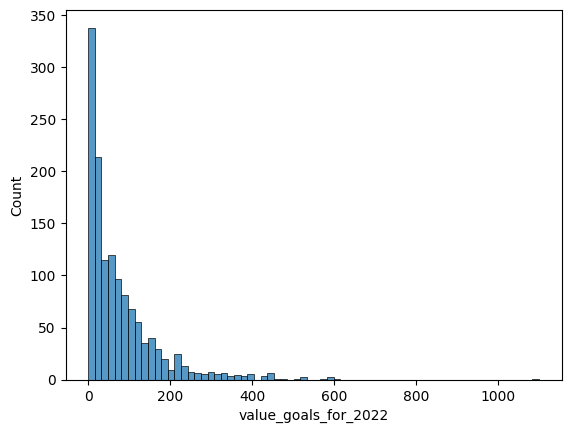

In [12]:
sns.histplot(df_cleaned["value_goals_for_2022"])